![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# DEDL - HDA Extreme DT Parameter Plotter - Tutorial

<br>Author: EUMETSAT</br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example to access and plot Extreme DT parameter.</br>


[Documentation DestinE DataLake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Extreme DT overview (for DESP testing period)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=414583259)


Import the Climate DT parameter & scenario dictionary

In [1]:
from destinelab import extreme_dt_dictionary
import ipywidgets as widgets
import json
import datetime

## Extreme DT parameter selection (we limit the plotting to one parameter)

In [2]:
# Create search box
search_box = widgets.Text(placeholder='Search by parameter name', description='Search:', disabled=False)

# Create dropdown to select entry
entry_dropdown = widgets.Dropdown(
    options=[(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params)],
    description='Select Entry:'
)

def filter_entries(search_string):
    return [(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params) if search_string.lower() in entry['paramName'].lower()]

def on_search_change(change):
    search_string = change.new
    if search_string:
        filtered_options = filter_entries(search_string)
        entry_dropdown.options = filtered_options
    else:
        entry_dropdown.options = [(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params)]

search_box.observe(on_search_change, names='value')

# Display widgets
display(search_box, entry_dropdown)

def get_selected_entry():
    return entry_dropdown.value


Text(value='', description='Search:', placeholder='Search by parameter name')

Dropdown(description='Select Entry:', options=(('Sea ice area fraction', 0), ('Sea surface temperature', 1), (…

# Print the details of the parameter (Polytope convention):

In [3]:

selected_index = get_selected_entry()
selected_entry = extreme_dt_dictionary.extremeDT_params[selected_index]
print(json.dumps(selected_entry,indent=4))

{
    "param": "168",
    "paramName": "2 metre dewpoint temperature",
    "shortName": "2d",
    "unit": "K",
    "encoding": "instantaneous",
    "stream": "oper",
    "type": "fc",
    "levtype": "sfc",
    "step": "0/1/to/96",
    "levelist": ""
}


## Select the Date of Observation to be selected

In [5]:
# Create dropdown to select scenario
scenario_dropdown = widgets.Dropdown(
    options=[(f"{entry['model']}", (i)) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_scenario)],
    description='Scenario:'
)

# Create date picker widgets
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False)

def on_scenario_change(change):
    selected_index = change.new
    selected_entry = extreme_dt_dictionary.extremeDT_scenario[selected_index]
    date_from = datetime.datetime.strptime(selected_entry['dateFrom'], '%m/%d/%Y').date()
    start_date_picker.min = date_from
    start_date_picker.max = datetime.datetime.strptime(selected_entry['dateTo'], '%m/%d/%Y').date()
    # Set the initial date of the start_date_picker to the scenario's start date
    start_date_picker.value = date_from
    selected_start_date = start_date_picker.value
    
scenario_dropdown.observe(on_scenario_change, names='value')

# Set initial values directly
selected_entry = extreme_dt_dictionary.extremeDT_scenario[0]
# Convert dateFrom string to date object
date_from = datetime.datetime.strptime(selected_entry['dateFrom'], '%m/%d/%Y').date()

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = datetime.datetime.strptime(selected_entry['dateTo'], '%m/%d/%Y').date()
start_date_picker.value = date_from

# Display widgets
display(scenario_dropdown, start_date_picker)

def get_selected_values():
    selected_scenario_index = scenario_dropdown.value
    selected_scenario = extreme_dt_dictionary.extremeDT_scenario[selected_scenario_index]
    selected_start_date = start_date_picker.value
    return selected_scenario_index, selected_scenario, selected_start_date

# Example usage:
selected_scenario_index, selected_scenario, selected_start_date = get_selected_values()


Dropdown(description='Scenario:', options=(('IFS-NEMO', 0),), value=0)

DatePicker(value=datetime.date(2024, 4, 4), description='Start Date:', max=datetime.date(2024, 4, 12), min=dat…

## Choose now the Steps within the observation to be retrieved (one step usually one hour)

In [6]:
selected_entry = extreme_dt_dictionary.extremeDT_params[selected_index]
input_string = selected_entry["step"]

def parse_input_string(input_string):
    ranges = input_string.split('/')
    step_start = ""
    step_end = ""
    step_width = 1
    hypen = ""
    options = []
    for rng in ranges:
        if rng:
            if '-' in rng:
                hypen = "-"
                start, end = rng.split('-')
                step_width = int(end) - int(start)
                if step_start == "":
                    step_start = int(start.strip())
                step_end = int(end.strip())
            elif 'to' not in rng:
                if step_start == "":
                    step_start = int(rng.strip())
                step_end = int(rng.strip())
                #options.append(option)
    #print(str(step_start) + ":" + str(step_end))
    if hypen != "":
        options.extend([f"{i}-{i+step_width}" for i in range(step_start, step_end, step_width)])
    else:
        options.extend([f"{i}" for i in range(step_start, step_end+1, step_width)])
    return options

def get_selected_step_values():
    selected_values = multi_select.value
    selected_values_string = "/".join(selected_values)
    return selected_values_string

options = parse_input_string(input_string)

multi_select = widgets.SelectMultiple(
    options=options,
    description='Select (Steps):',
    disabled=False
)

display(multi_select)


SelectMultiple(description='Select:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '…

## Handle different Levels to be selected (if any)

In [7]:
# Define a global variable
global global_widget
global_widget = None

if selected_entry["levelist"] != "":
    # Convert levelist string to list of integers
    levelist = list(map(int, selected_entry["levelist"].split('/')))

      
    # Create a function to generate the widget based on the selection mode
    def generate_widget(selection_mode):
        global global_widget
        if selection_mode == 'Single':
            global_widget = widgets.Dropdown(options=levelist, description='Select level:')
            return global_widget
        elif selection_mode == 'Multiple':
            global_widget = widgets.SelectMultiple(options=levelist, description='Select levels:')
            return global_widget

    # Create a dropdown widget to choose selection mode
    selection_mode_dropdown = widgets.Dropdown(options=['Single', 'Multiple'], description='Selection Mode:')

    # Create an output widget to display the selected option(s)
    output = widgets.Output()

    # Function to display the widget based on the selection mode
    def display_widget(selection_mode):
        output.clear_output()
        with output:
            display(generate_widget(selection_mode))

    # Define a function to handle the change in selection mode
    def on_dropdown_change(change):
        display_widget(change.new)

    # Register the function to handle dropdown changes
    selection_mode_dropdown.observe(on_dropdown_change, names='value')

    # Display the widgets
    display(selection_mode_dropdown, output)

    # Display the initial widget based on default selection mode
    display_widget('Single')

In [8]:
# Function to convert tuple or single integer to string separated by "/"
def convert_to_string(input):
    if isinstance(input, tuple):
        return '/'.join(map(str, input))
    elif isinstance(input, int):
        return str(input)
    else:
        return None  # Handle other types if needed

levlInput = ""
if global_widget != None:
    # Test cases
    levlInput = convert_to_string(global_widget.value)


In [9]:
# Call get_selected_values after the display is finished
selected_step_values = get_selected_step_values()

# Print the result in JSON format
#datechoice = get_selected_values()[2].strftime('%Y%m%d')
datechoice = "{fname}T00:00:00Z".format(fname = get_selected_values()[2])

filter_params = {
  "class": "d1",                       # fixed 
  "dataset": "extremes-dt",             # fixed extreme-dt access
  "expver": "0001",                    # fixed experiment version 
  "stream": selected_entry["stream"],
  "type": "fc",                        # fixed forecasted fields
#  "date": datechoice,                  # choose the date
  "time": "0000",                      # fixed 
  "step": selected_step_values,        # step choice 
  "levtype": selected_entry["levtype"],  
  "levelist": str(levlInput),  
  "param": str(selected_entry["param"]),  
}

# Print the result in JSON format
print(datechoice)
print(json.dumps(filter_params, indent=4))

2024-04-04T00:00:00Z
{
    "class": "d1",
    "dataset": "extremes-dt",
    "expver": "0001",
    "stream": "oper",
    "type": "fc",
    "time": "0000",
    "step": "0/1",
    "levtype": "sfc",
    "levelist": "",
    "param": "168"
}


## Obtain Authentication Token

In [10]:
import requests
import json
import os
from getpass import getpass
import destinelab as deauth

### Query using the DEDL HDA API


In [12]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Filter
We have to setup up a filter and define which data to obtain.

In [13]:
# Check if levelist is empty and remove it
if filter_params.get("levelist") == "":
    del filter_params["levelist"]
   
hdaFilters = {
    key: {"eq": value}
    for key, value in filter_params.items()
}

#print(hdaFilters)

## Make Data Request
Please repeat this call is you have a timeout failure (under investion in the moment)

In [14]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.DT_EXTREMES"],
    "datetime": datechoice,
    "query": hdaFilters
})

# Requests to EO.ECMWF.DAT.DT_CLIMATE always return a single item containing all the requested data
#print(response.json())
product = response.json()["features"][0]
#product

## Submission worked ? Once our product found, we download the data.

In [15]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
print(download_url)
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    JSON(response.json(), expanded=True)
    

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20240404_20240404_3d838d4bb8b9832b513e93fadc6e85f6fd4b875a/download?provider=polytope_lumi&_dc_qs=%257B%2522class%2522%253A%252B%2522d1%2522%252C%252B%2522dataset%2522%253A%252B%2522extremes-dt%2522%252C%252B%2522date%2522%253A%252B%252220240404%2Fto%2F20240404%2522%252C%252B%2522expver%2522%253A%252B%25220001%2522%252C%252B%2522levtype%2522%253A%252B%2522sfc%2522%252C%252B%2522param%2522%253A%252B168%252C%252B%2522step%2522%253A%252B%25220%2F1%2522%252C%252B%2522stream%2522%253A%252B%2522oper%2522%252C%252B%2522time%2522%253A%252B0%252C%252B%2522type%2522%253A%252B%2522fc%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [16]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()
       
# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response.headers)
    print(response.json())
    raise Exception("Content-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
order status: processing
order status: processing
order status: processing
downloading 639f946c-dfef-4f3e-b49f-ae12fef078e7.grib


100%|██████████| 105M/105M [00:03<00:00, 29.9MB/s] 


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [17]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

29d0b9185cd86c237eeba2b6dd05d7b7548d9b0f1355b1bd1070314b59e085a0.npz:   0%|          | 0.00/1.21M [00:00<?, ?B…

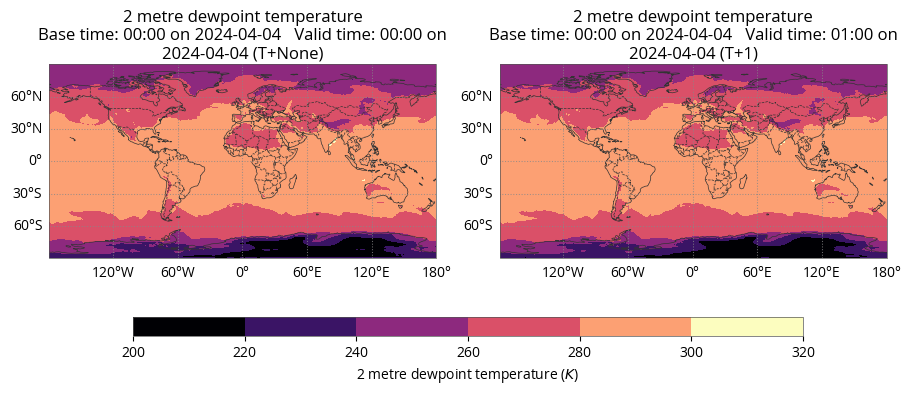

In [18]:
data = earthkit.data.from_source("file", filename)
data.ls

earthkit.maps.quickplot(data, #style=style
                       )